# Cell Cycle Scoring

This notebook explores the cell cycle scores in the at-scale screen using the Seurat single-cell RNA-seq analysis package, and generates a plot that demonstrates that the cells separate based on their cell cycle phase. Additionally, this notebook explores some of the missingness encountered when determining the cell cycle scores in the dataset. This code is heavily adapted from the Seurat cell cycle scoring and regression vignette available at: https://satijalab.org/seurat/articles/cell_cycle_vignette.html

Author: Karthik Guruvayurappan

In [ ]:
library('Seurat')
library('Matrix')
library('biomaRt')
library(ggplot2)

In [ ]:
# load in UMI count (expression) matrix from at-scale screen
expression.matrix <- readMM('/iblm/netapp/data1/external/Gasperini2019/suppl/GSE120861_at_scale_screen.exprs.mtx')
head(expression.matrix)

6 x 207324 sparse Matrix of class "dgTMatrix"
                                                                               
[1,] . . . . . . . . . . . . . . . . . . . . . . . . 1 . 1 . . . . . . . ......
[2,] 1 . . . . . . . . . . . . . 2 . 1 . . . . . . . 1 . . . . . . 1 . . ......
[3,] 1 . 1 1 1 . . . . 1 1 . . . 3 . 4 1 . . . 1 . . 1 1 1 1 1 1 . . . . ......
[4,] . . . 1 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . ......
[5,] . . 1 . . . . 1 . . . . . . . . . . . . . . . . . 1 . . . . 1 . . . ......
[6,] . . . . . . . . . . . . . . . . 1 . . . . . . . . . . . . . . . . . ......

 .....suppressing 207290 columns in show(); maybe adjust 'options(max.print= *, width = *)'
 ..............................

In [ ]:
# convert expression matrix from matrix to data frame format
expression.matrix <- as.data.frame(expression.matrix)
head(expression.matrix)

Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 20.3 GiB”


,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,⋯,V207315,V207316,V207317,V207318,V207319,V207320,V207321,V207322,V207323,V207324
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,⋯,0,0,0,1,0,0,0,1,0,0
3,1,0,1,1,1,0,0,0,0,1,⋯,0,0,0,0,1,0,0,2,0,2
4,0,0,0,1,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
5,0,0,1,0,0,0,0,1,0,0,⋯,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0


In [ ]:
# read in column names and add to expression matrix
cell.barcodes <- read.delim('/iblm/netapp/data1/external/Gasperini2019/suppl/GSE120861_at_scale_screen.cells.txt', header = FALSE)
cell.barcodes <- cell.barcodes$V1
colnames(expression.matrix) <- cell.barcodes
head(expression.matrix)

,AAACCTGAGAGGTACC-1_1A_1_SI-GA-E2,AAACCTGAGTCAATAG-1_1A_1_SI-GA-E2,AAACCTGCAAACAACA-1_1A_1_SI-GA-E2,AAACCTGCACTTCTGC-1_1A_1_SI-GA-E2,AAACCTGCATGTAGTC-1_1A_1_SI-GA-E2,AAACCTGGTAGCGCAA-1_1A_1_SI-GA-E2,AAACCTGGTAGGGACT-1_1A_1_SI-GA-E2,AAACCTGGTATATGAG-1_1A_1_SI-GA-E2,AAACCTGGTCAAAGCG-1_1A_1_SI-GA-E2,AAACCTGGTCTTCAAG-1_1A_1_SI-GA-E2,⋯,TTTGTCACAACGATGG-1_2B_8_SI-GA-H9,TTTGTCACACTTCTGC-1_2B_8_SI-GA-H9,TTTGTCACAGATAATG-1_2B_8_SI-GA-H9,TTTGTCACAGCCAGAA-1_2B_8_SI-GA-H9,TTTGTCACATTAGGCT-1_2B_8_SI-GA-H9,TTTGTCAGTACCTACA-1_2B_8_SI-GA-H9,TTTGTCAGTATCACCA-1_2B_8_SI-GA-H9,TTTGTCAGTTCAGACT-1_2B_8_SI-GA-H9,TTTGTCAGTTCTGTTT-1_2B_8_SI-GA-H9,TTTGTCATCAAAGTAG-1_2B_8_SI-GA-H9
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,⋯,0,0,0,1,0,0,0,1,0,0
3,1,0,1,1,1,0,0,0,0,1,⋯,0,0,0,0,1,0,0,2,0,2
4,0,0,0,1,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
5,0,0,1,0,0,0,0,1,0,0,⋯,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0


In [ ]:
# read in row names and add to expression matrix
genes <- read.delim('/iblm/netapp/data1/external/Gasperini2019/suppl/GSE120861_at_scale_screen.genes.txt', header = FALSE)
genes <- genes$V1
rownames(expression.matrix) <- genes
head(expression.matrix)

,AAACCTGAGAGGTACC-1_1A_1_SI-GA-E2,AAACCTGAGTCAATAG-1_1A_1_SI-GA-E2,AAACCTGCAAACAACA-1_1A_1_SI-GA-E2,AAACCTGCACTTCTGC-1_1A_1_SI-GA-E2,AAACCTGCATGTAGTC-1_1A_1_SI-GA-E2,AAACCTGGTAGCGCAA-1_1A_1_SI-GA-E2,AAACCTGGTAGGGACT-1_1A_1_SI-GA-E2,AAACCTGGTATATGAG-1_1A_1_SI-GA-E2,AAACCTGGTCAAAGCG-1_1A_1_SI-GA-E2,AAACCTGGTCTTCAAG-1_1A_1_SI-GA-E2,⋯,TTTGTCACAACGATGG-1_2B_8_SI-GA-H9,TTTGTCACACTTCTGC-1_2B_8_SI-GA-H9,TTTGTCACAGATAATG-1_2B_8_SI-GA-H9,TTTGTCACAGCCAGAA-1_2B_8_SI-GA-H9,TTTGTCACATTAGGCT-1_2B_8_SI-GA-H9,TTTGTCAGTACCTACA-1_2B_8_SI-GA-H9,TTTGTCAGTATCACCA-1_2B_8_SI-GA-H9,TTTGTCAGTTCAGACT-1_2B_8_SI-GA-H9,TTTGTCAGTTCTGTTT-1_2B_8_SI-GA-H9,TTTGTCATCAAAGTAG-1_2B_8_SI-GA-H9
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ENSG00000238009,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
ENSG00000237683,1,0,0,0,0,0,0,0,0,0,⋯,0,0,0,1,0,0,0,1,0,0
ENSG00000228463,1,0,1,1,1,0,0,0,0,1,⋯,0,0,0,0,1,0,0,2,0,2
ENSG00000237094,0,0,0,1,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
ENSG00000235373,0,0,1,0,0,0,0,1,0,0,⋯,0,0,0,0,0,0,0,0,0,0
ENSG00000228327,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0


In [ ]:
print(length(genes))

[1] 13135


In [ ]:
# code snippet adapted from: https://stackoverflow.com/questions/28543517/how-can-i-convert-ensembl-id-to-gene-symbol-in-r
mart <- useDataset("hsapiens_gene_ensembl", useMart("ensembl"))
gene.symbols <- getBM(
    filters = "ensembl_gene_id",
    attributes = c("ensembl_gene_id", "hgnc_symbol"),
    values = genes,
    mart = mart,
)

In [ ]:
gene.symbols[gene.symbols$ensembl_gene_id == 'ENSG00000237683', ]

ensembl_gene_id,hgnc_symbol
<chr>,<chr>


In [ ]:
nrow(gene.symbols)

[1] 12786

In [ ]:
head(gene.symbols)

,ensembl_gene_id,hgnc_symbol
,<chr>,<chr>
1,ENSG00000000457,SCYL3
2,ENSG00000000460,C1orf112
3,ENSG00000000971,CFH
4,ENSG00000001167,NFYA
5,ENSG00000001460,STPG1
6,ENSG00000001461,NIPAL3


In [ ]:
# summarize missingness in mapping process
sum(gene.symbols$hgnc_symbol == "")

[1] 591

In [ ]:
# merge with original gene symbols to retain gene ordering
gene.symbols <- merge(data.frame(genes), gene.symbols, all.x = TRUE, by.x = 'genes', by.y = 'ensembl_gene_id', sort = FALSE)

In [ ]:
head(data.frame(genes))

,genes
,<chr>
1,ENSG00000238009
2,ENSG00000237683
3,ENSG00000228463
4,ENSG00000237094
5,ENSG00000235373
6,ENSG00000228327


In [ ]:
gene.symbols[gene.symbols$genes == 'ENSG00000237683', ]

,genes,hgnc_symbol
,<chr>,<chr>
12788,ENSG00000237683,NA


In [ ]:
gene.symbols <- merge(data.frame(genes), gene.symbols, by = 'genes', sort = FALSE)

In [ ]:
head(gene.symbols, 20)

,genes,hgnc_symbol
,<chr>,<chr>
1,ENSG00000238009,
2,ENSG00000237683,NA
3,ENSG00000228463,
4,ENSG00000237094,
5,ENSG00000235373,NA
6,ENSG00000228327,
7,ENSG00000237491,LINC01409
8,ENSG00000225880,LINC00115
9,ENSG00000230368,FAM41C


In [ ]:
gene.symbols[is.na(gene.symbols)] <- ''
sum(is.na(gene.symbols$hgnc_symbol))

[1] 0

In [ ]:
print(nrow(gene.symbols))

[1] 13135


In [ ]:
print(head(gene.symbols))

            genes hgnc_symbol
1 ENSG00000238009            
2 ENSG00000237683            
3 ENSG00000228463            
4 ENSG00000237094            
5 ENSG00000235373            
6 ENSG00000228327            


In [ ]:
for (i in 1:nrow(gene.symbols)) {
    if (gene.symbols[i, 'hgnc_symbol'] == '') {
        gene.symbols[i, 'hgnc_symbol'] <- gene.symbols[i, 'genes']
    }
}
head(gene.symbols, 20)

,genes,hgnc_symbol
,<chr>,<chr>
1,ENSG00000238009,ENSG00000238009
2,ENSG00000237683,ENSG00000237683
3,ENSG00000228463,ENSG00000228463
4,ENSG00000237094,ENSG00000237094
5,ENSG00000235373,ENSG00000235373
6,ENSG00000228327,ENSG00000228327
7,ENSG00000237491,LINC01409
8,ENSG00000225880,LINC00115
9,ENSG00000230368,FAM41C


In [ ]:
rownames(expression.matrix) <- gene.symbols[, 'hgnc_symbol']

In [ ]:
head(expression.matrix)

,AAACCTGAGAGGTACC-1_1A_1_SI-GA-E2,AAACCTGAGTCAATAG-1_1A_1_SI-GA-E2,AAACCTGCAAACAACA-1_1A_1_SI-GA-E2,AAACCTGCACTTCTGC-1_1A_1_SI-GA-E2,AAACCTGCATGTAGTC-1_1A_1_SI-GA-E2,AAACCTGGTAGCGCAA-1_1A_1_SI-GA-E2,AAACCTGGTAGGGACT-1_1A_1_SI-GA-E2,AAACCTGGTATATGAG-1_1A_1_SI-GA-E2,AAACCTGGTCAAAGCG-1_1A_1_SI-GA-E2,AAACCTGGTCTTCAAG-1_1A_1_SI-GA-E2,⋯,TTTGTCACAACGATGG-1_2B_8_SI-GA-H9,TTTGTCACACTTCTGC-1_2B_8_SI-GA-H9,TTTGTCACAGATAATG-1_2B_8_SI-GA-H9,TTTGTCACAGCCAGAA-1_2B_8_SI-GA-H9,TTTGTCACATTAGGCT-1_2B_8_SI-GA-H9,TTTGTCAGTACCTACA-1_2B_8_SI-GA-H9,TTTGTCAGTATCACCA-1_2B_8_SI-GA-H9,TTTGTCAGTTCAGACT-1_2B_8_SI-GA-H9,TTTGTCAGTTCTGTTT-1_2B_8_SI-GA-H9,TTTGTCATCAAAGTAG-1_2B_8_SI-GA-H9
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ENSG00000238009,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
ENSG00000237683,1,0,0,0,0,0,0,0,0,0,⋯,0,0,0,1,0,0,0,1,0,0
ENSG00000228463,1,0,1,1,1,0,0,0,0,1,⋯,0,0,0,0,1,0,0,2,0,2
ENSG00000237094,0,0,0,1,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
ENSG00000235373,0,0,1,0,0,0,0,1,0,0,⋯,0,0,0,0,0,0,0,0,0,0
ENSG00000228327,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0


In [ ]:
s.genes <- cc.genes$s.genes
g2m.genes <- cc.genes$g2m.genes

In [ ]:
gene.expression <- CreateSeuratObject(counts = expression.matrix)
gene.expression

An object of class Seurat 
13135 features across 207324 samples within 1 assay 
Active assay: RNA (13135 features, 0 variable features)

In [ ]:
gene.expression <- NormalizeData(gene.expression)
gene.expression

An object of class Seurat 
13135 features across 207324 samples within 1 assay 
Active assay: RNA (13135 features, 0 variable features)

In [ ]:
gene.expression <- FindVariableFeatures(gene.expression, selection.method  = "vst")
gene.expression

An object of class Seurat 
13135 features across 207324 samples within 1 assay 
Active assay: RNA (13135 features, 2000 variable features)

In [ ]:
gene.expression <- ScaleData(gene.expression, features = rownames(gene.expression))
gene.expression

Centering and scaling data matrix



An object of class Seurat 
13135 features across 207324 samples within 1 assay 
Active assay: RNA (13135 features, 2000 variable features)

In [ ]:
gene.expression <- RunPCA(gene.expression, features = VariableFeatures(gene.expression), ndims.print = 1:5, nfeatures.print = 10)
gene.expression

PC_ 1 
Positive:  NME1, EIF5A, SRM, CHCHD2, ODC1, PRELID1, TIMM13, RANBP1, EBNA1BP2, AURKAIP1 
Negative:  SNHG32, ZFAS1, EPB41L4A-AS1, ALAS2, FTH1, SLC25A37, YPEL3, ENSG00000117289, PNRC1, EIF4A2 
PC_ 2 
Positive:  VIM, PKM, S100A11, TPM4, CLIC1, SQSTM1, STX3, TMSB10, JUN, RHOC 
Negative:  HBZ, HBA1, HBA2, HBG1, HEMGN, HBG2, PRDX2, ALAS2, HBE1, HMBS 
PC_ 3 
Positive:  CCNB1, CDC20, HMMR, PLK1, AURKA, CCNB2, PTTG1, NEK2, HMGB2, CCNA2 
Negative:  SH3BGRL3, MT-CO2, MT-ND4, MT-CO1, MT-ND1, MT-ND2, MT-CYB, MT-CO3, FTL, NEAT1 
PC_ 4 
Positive:  PRDX1, HBG1, HBG2, EIF4A1, UBB, PRDX2, GYPA, CCT5, EIF2S1, ENO1 
Negative:  TOP2A, PIF1, CENPA, CENPF, ASPM, MKI67, ENSG00000227706, TPX2, TMSB10, MT-ND1 
PC_ 5 
Positive:  H1-2, H2AC6, H2BC4, H2BC12, LBH, HBG2, DYNLL1, HSPB1, HBA1, RNASE1 
Negative:  TRIB3, DDIT4, PSAT1, MTHFD2, ATF4, WARS1, MAP1B, GARS1, EIF4EBP1, ASNS 



An object of class Seurat 
13135 features across 207324 samples within 1 assay 
Active assay: RNA (13135 features, 2000 variable features)
 1 dimensional reduction calculated: pca

In [ ]:
gene.expression <- CellCycleScoring(gene.expression, s.features = s.genes, g2m.features = g2m.genes, set.ident = TRUE)

# view cell cycle scores and phase assignments
head(gene.expression[[]])

Warning message:
“The following features are not present in the object: UHRF1, MLF1IP, CASP8AP2, not searching for symbol synonyms”
Warning message:
“The following features are not present in the object: UBE2C, FAM64A, HN1, not searching for symbol synonyms”


,orig.ident,nCount_RNA,nFeature_RNA,S.Score,G2M.Score,Phase,old.ident
,<fct>,<dbl>,<int>,<dbl>,<dbl>,<chr>,<fct>
AAACCTGAGAGGTACC-1_1A_1_SI-GA-E2,SeuratProject,17566,3549,0.110732311,-0.1319208,S,SeuratProject
AAACCTGAGTCAATAG-1_1A_1_SI-GA-E2,SeuratProject,8917,2543,-0.010290919,-0.1535426,G1,SeuratProject
AAACCTGCAAACAACA-1_1A_1_SI-GA-E2,SeuratProject,14626,3191,-0.175860130,-0.3084879,G1,SeuratProject
AAACCTGCACTTCTGC-1_1A_1_SI-GA-E2,SeuratProject,22783,4539,0.003057281,-0.1574859,S,SeuratProject
AAACCTGCATGTAGTC-1_1A_1_SI-GA-E2,SeuratProject,10124,2605,-0.144480961,-0.2362154,G1,SeuratProject
AAACCTGGTAGCGCAA-1_1A_1_SI-GA-E2,SeuratProject,9743,2187,0.026418076,-0.1462899,S,SeuratProject


In [ ]:
s.genes

[1] "MCM5"     "PCNA"     "TYMS"     "FEN1"     "MCM2"     "MCM4"    
 [7] "RRM1"     "UNG"      "GINS2"    "MCM6"     "CDCA7"    "DTL"     
[13] "PRIM1"    "UHRF1"    "MLF1IP"   "HELLS"    "RFC2"     "RPA2"    
[19] "NASP"     "RAD51AP1" "GMNN"     "WDR76"    "SLBP"     "CCNE2"   
[25] "UBR7"     "POLD3"    "MSH2"     "ATAD2"    "RAD51"    "RRM2"    
[31] "CDC45"    "CDC6"     "EXO1"     "TIPIN"    "DSCC1"    "BLM"     
[37] "CASP8AP2" "USP1"     "CLSPN"    "POLA1"    "CHAF1B"   "BRIP1"   
[43] "E2F8"

In [ ]:
g2m.genes

[1] "HMGB2"   "CDK1"    "NUSAP1"  "UBE2C"   "BIRC5"   "TPX2"    "TOP2A"  
 [8] "NDC80"   "CKS2"    "NUF2"    "CKS1B"   "MKI67"   "TMPO"    "CENPF"  
[15] "TACC3"   "FAM64A"  "SMC4"    "CCNB2"   "CKAP2L"  "CKAP2"   "AURKB"  
[22] "BUB1"    "KIF11"   "ANP32E"  "TUBB4B"  "GTSE1"   "KIF20B"  "HJURP"  
[29] "CDCA3"   "HN1"     "CDC20"   "TTK"     "CDC25C"  "KIF2C"   "RANGAP1"
[36] "NCAPD2"  "DLGAP5"  "CDCA2"   "CDCA8"   "ECT2"    "KIF23"   "HMMR"   
[43] "AURKA"   "PSRC1"   "ANLN"    "LBR"     "CKAP5"   "CENPE"   "CTCF"   
[50] "NEK2"    "G2E3"    "GAS2L3"  "CBX5"    "CENPA"

In [ ]:
# Running a PCA on cell cycle genes reveals, unsurprisingly, that cells separate entirely by
# phase
gene.expression <- RunPCA(gene.expression, features = c(s.genes, g2m.genes))
cell.cycle.pca <- DimPlot(gene.expression)

Warning message in PrepDR(object = object, features = features, verbose = verbose):
“The following 6 features requested have not been scaled (running reduction without them): UHRF1, MLF1IP, CASP8AP2, UBE2C, FAM64A, HN1”
Warning message in irlba(A = t(x = object), nv = npcs, ...):
“You're computing too large a percentage of total singular values, use a standard svd instead.”
PC_ 1 
Positive:  TOP2A, CENPF, TPX2, AURKA, HMGB2, HMMR, CKS1B, BIRC5, MKI67, CENPA 
	   DLGAP5, NUSAP1, CDC20, PSRC1, NEK2, CENPE, CDCA8, CKS2, KIF2C, CDK1 
	   BUB1, NUF2, AURKB, CDCA3, CKAP2, TACC3, NDC80, CCNB2, GTSE1, TUBB4B 
Negative:  UNG, CCNE2, MCM5, DTL, POLD3, WDR76, HELLS, MCM2, CHAF1B, BRIP1 
	   MCM6, POLA1, CDC6, TIPIN, UBR7, CDCA7, MCM4, RPA2, GINS2, DSCC1 
	   RAD51, FEN1, CDC45, RFC2, SLBP, E2F8, PCNA, CTCF, EXO1, PRIM1 
PC_ 2 
Positive:  PSRC1, AURKA, CCNB2, CENPA, CDC20, CENPE, NEK2, CDC25C, HMMR, CDCA8 
	   G2E3, GAS2L3, CKS2, GTSE1, CKAP2, CDCA2, TTK, DLGAP5, NUF2, NDC80 
	   CKAP2L, NCAPD2, B

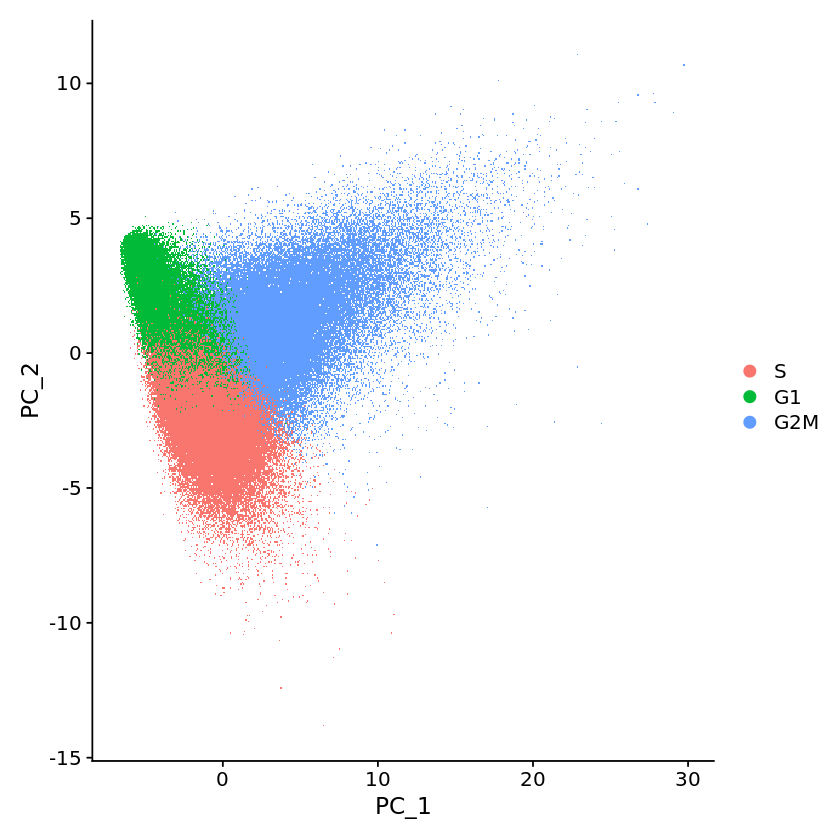

In [ ]:
cell.cycle.pca